# Bike Sharing Demand

참고문헌 : https://github.com/corazzon/KaggleStruggle/blob/master/bike-sharing-demand/bike-sharing-demand-EDA.ipynb

## Data Description

See, fork, and run a random forest benchmark model through Kaggle Scripts

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

* 분류와 회귀 문제 중 회귀 관련된 문제
    - 레이블이 있기 때문에 지도학습에 해당
    - 예측하는 문제 이기 때문에 회귀에 관련된 문제

## Data Fields

**datetime** - hourly date + timestamp

**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

**holiday** - whether the day is considered a holiday

**workingday** - whether the day is neither a weekend nor holiday

**weather** -
<br>1: Clear, Few clouds, Partly cloudy, Partly cloudy
<br>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
<br>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
<br>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated

**registered** - number of registered user rentals initiated

**count** - number of total rentals

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
#parse_datas = ["컬럼명"] 
#해당 컬럼을 자동으로 날짜 방식으로 읽어옴
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
# train.columns
# train.dtypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


바람의 경우 0 이 많다. 어쩌면 측정이 안된 경우 0을 넣어준것이 아닐까 싶다.

### Null 값이 있는지 확인(2가지 방법)

* 하나는 Null의 갯수를 세보는 방법

* 다른 하나는 그래프를 그려보는 방법

In [5]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

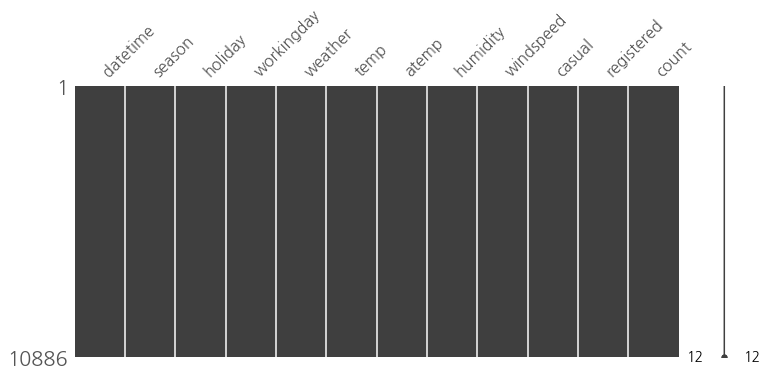

In [6]:
import missingno as msno

msno.matrix(train, figsize=(12,5))

## 시간을 다 쪼개서 분리하자

In [7]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train.shape

(10886, 18)

In [8]:
train.head(100)
#테이블의 맨 오른쪽을 확인하자

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2011-01-05 04:00:00,1,0,1,1,9.84,11.365,48,15.0013,0,2,2,2011,1,5,4,0,0
96,2011-01-05 05:00:00,1,0,1,1,9.02,11.365,47,11.0014,0,3,3,2011,1,5,5,0,0
97,2011-01-05 06:00:00,1,0,1,1,8.20,9.850,47,15.0013,0,33,33,2011,1,5,6,0,0
98,2011-01-05 07:00:00,1,0,1,1,7.38,9.090,43,12.9980,1,87,88,2011,1,5,7,0,0


[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

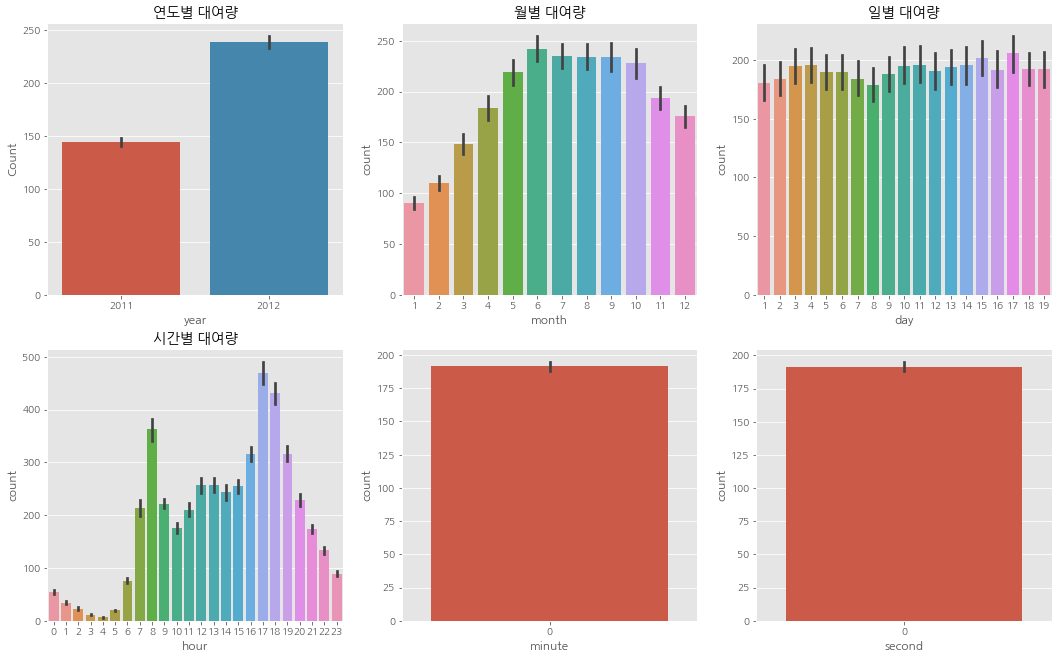

In [9]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
#열 2개, 행 3개 서브 그래프를 가지도록
figure.set_size_inches(18,11)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)
#일별 대여량을 19일까지 밖에 없으니 사용하면 안된다
sns.barplot(data=train, x="hour", y="count", ax=ax4)
#분,초는 데이터가 1가지이기 때문에 사용할수 없다
sns.barplot(data=train, x="minute", y="count", ax=ax5)
sns.barplot(data=train, x="second", y="count", ax=ax6)

ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")

* 많이 사용하는 시간대를 보면 8시, 17~18시에 유난히 이용량이 많다. 즉, 통학, 출퇴근 시간에 많이 이용한다는 것이다.
* 새벽 2시에서 5시 사이에 자전거를 이동시키는 것이 중요하다.
* 해당 데이터는 워싱턴 DC에서 얻어졌다. 날씨에 대해서 살펴보자
![기온 그래프](img/temp.png)
![강우 확률 그래프](img/rain.png)

### 여기서 생각해볼 수 있는 것들은
- 추운 날씨인 경우 자건거의 사용량에 매우 큰 영향을 준다.
- 강우 확률은 크게 영향을 안 줄 수도 있다. 6, 7월에 비가 가장 많은 날 오지만 대여량이 가장 많다.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

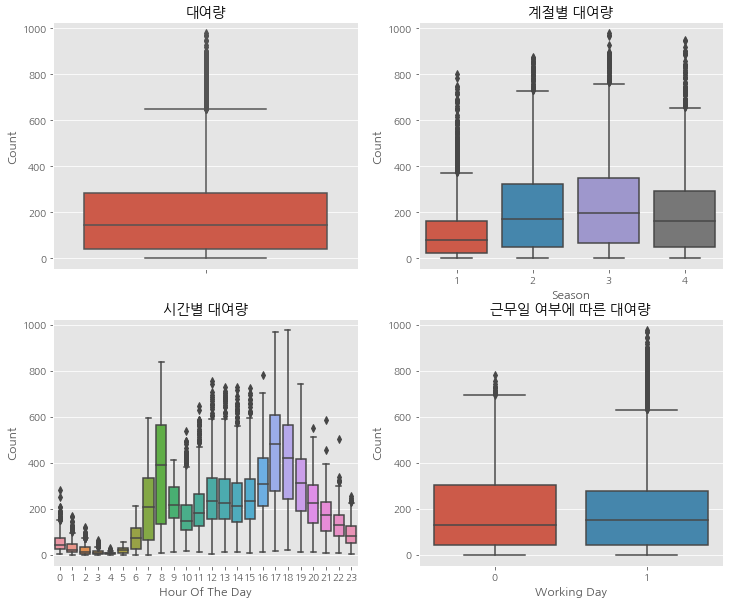

In [10]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="대여량")
axes[0][1].set(xlabel='Season', ylabel='Count',title="계절별 대여량")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="시간별 대여량")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="근무일 여부에 따른 대여량")

* 박스 플롯 읽는 방법
http://statistics4everyone.blogspot.com/2016/02/boxplot.html


In [11]:
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [12]:
train["dayofweek"].value_counts()


5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

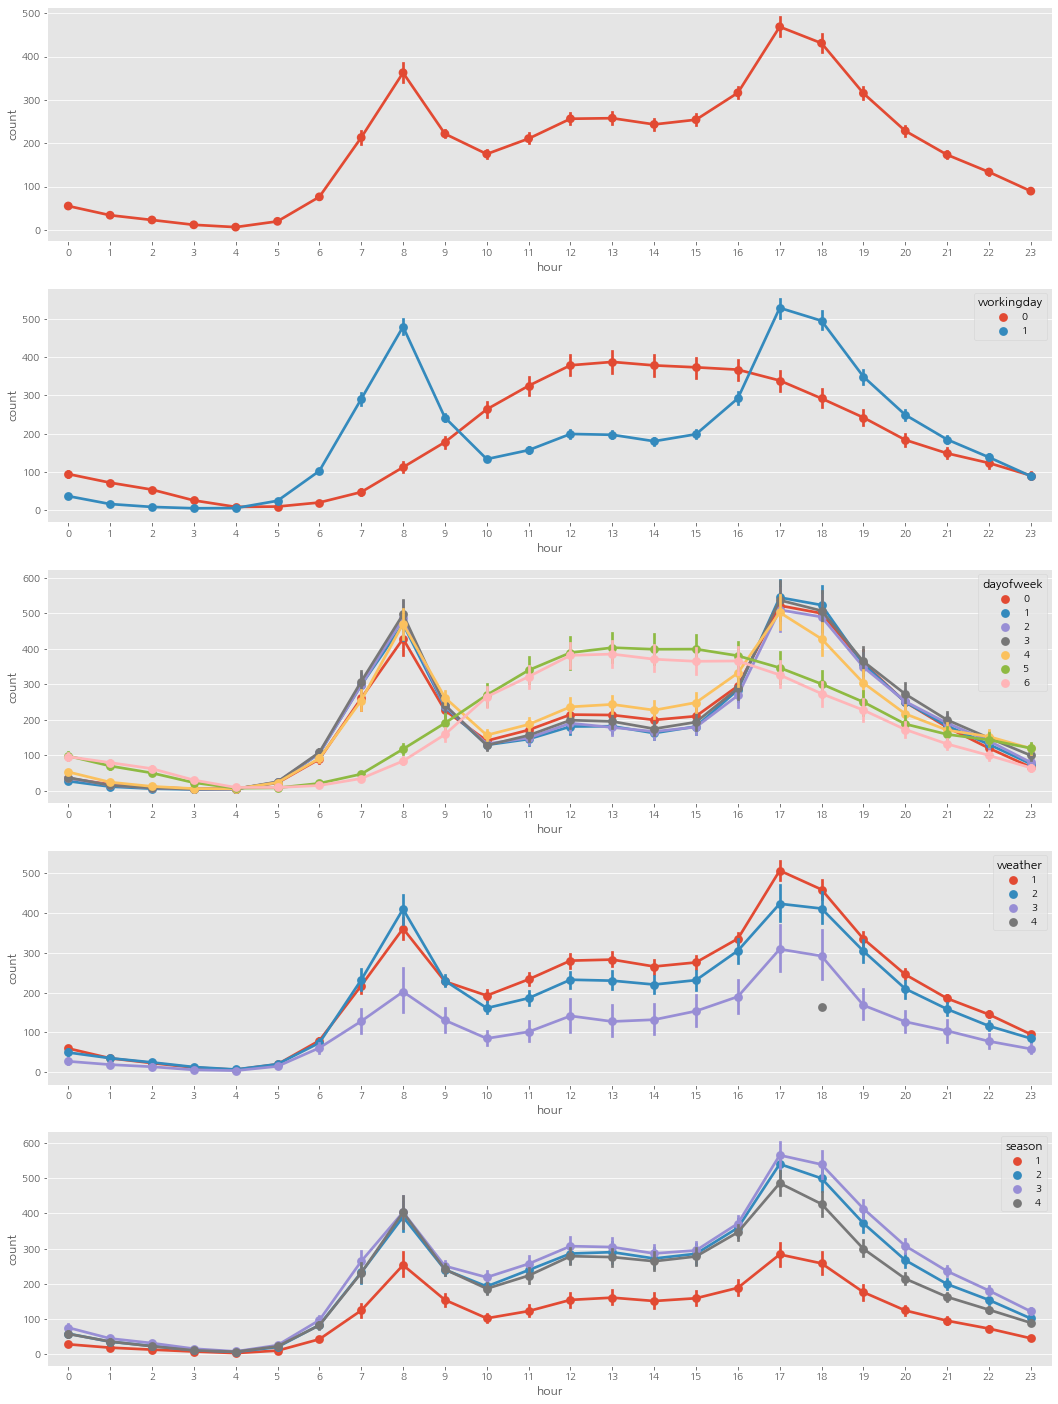

In [13]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)

sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)

sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)

sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)

sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

- 근무일과 휴일의 차이는 명확하게 들어난다.
- 휴일에는 오후 시간에 이용량이 많다.
- 강우가 있는 날은 이용량이 적다.
- 봄에 이용량이 적다? 이상한데?

In [14]:
corrMatt = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]
corrMatt = corrMatt.corr()    #연관 관계를 구해보는 함수
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


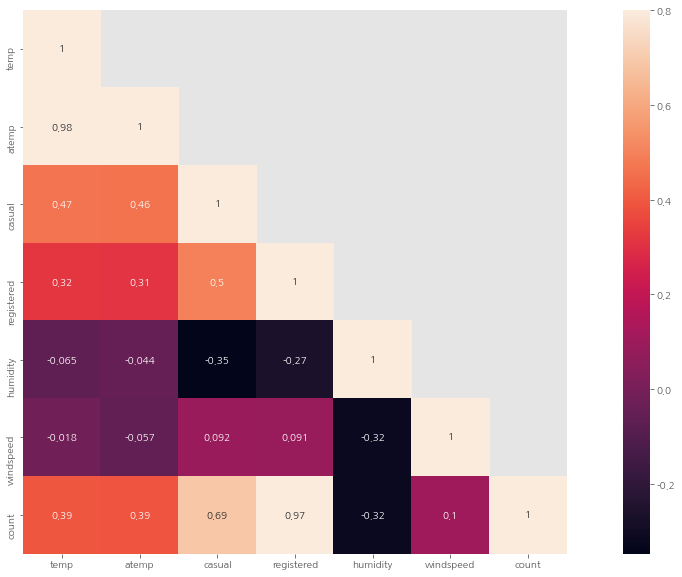

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

- 온도와 습도, 온도와 풍속은 연관 관계가 없다.
- count는 casual와 registered는 연관성이 높으나, test 데이터에는 없으므로 학습에 적합하지 않다. -> 정답률에 영향을 주지 못한다.
- atemp와 temp는 상관관계가 높지만, 둘의 상관관계가 너무 높아 둘다 학습데이터로 사용하는 것은 좋지 않을 수 있다.

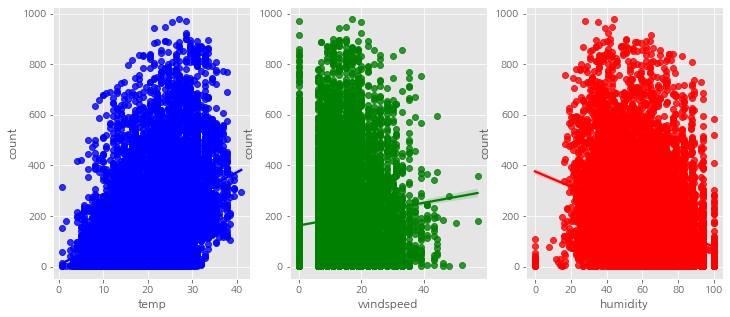

In [23]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=train,ax=ax1, color='b')
sns.regplot(x="windspeed", y="count", data=train,ax=ax2, color='g')
sns.regplot(x="humidity", y="count", data=train,ax=ax3 , color='r')

#선점도

- 풍속은 0에 데이터가 몰려 있기 피쳐엔지리어링에서 조정을 해주면 좋은 점수를 얻을수 있을 것이다. 아마도..

In [17]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "year_month"]].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


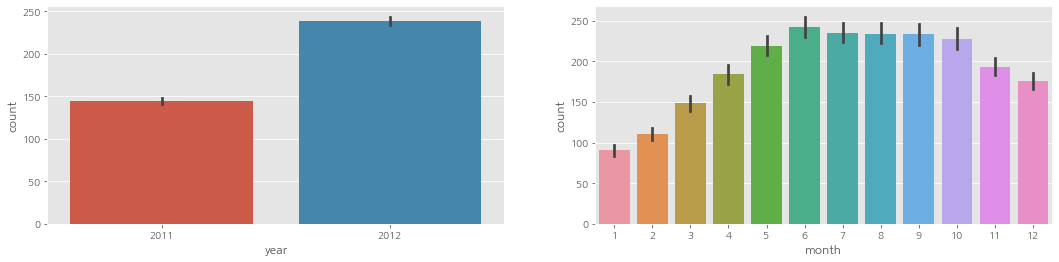

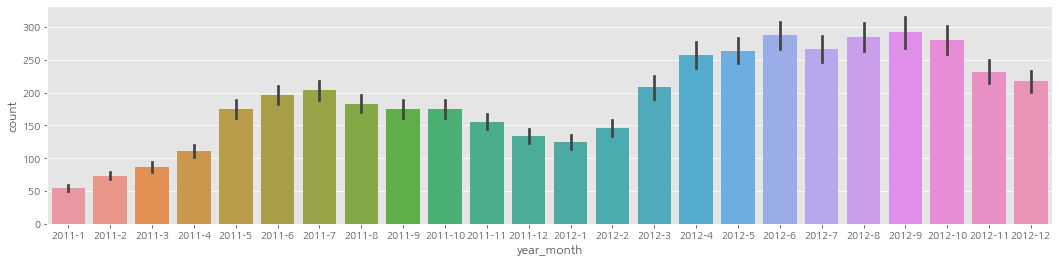

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year_month", y="count", ax=ax3)

#월별 이용량을 확인하기 위해

사용량이 점점 증가하는 것을 볼수 있다

In [24]:
# trainWithoutOutliers
# 아웃라이더를 제거함
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229767, 4.562423868087808, 0.958117678090961))

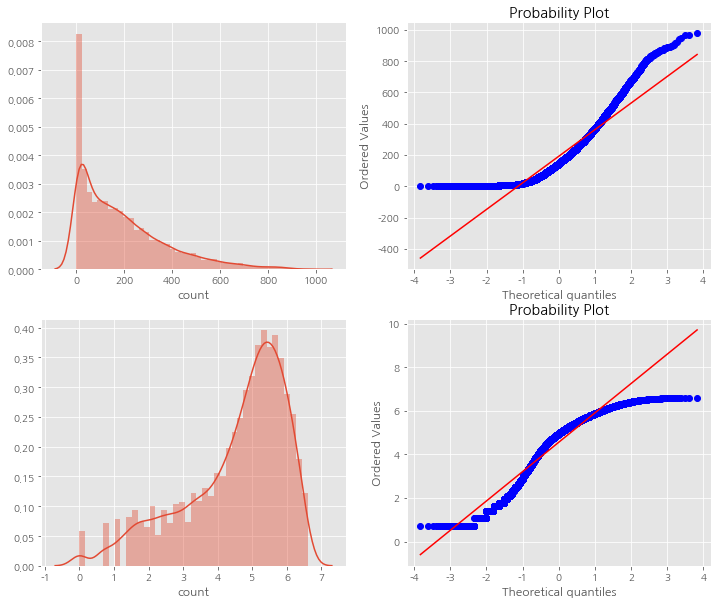

In [20]:
# count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train["count"], ax=axes[0][0])   # count가 0인 경우를 제거하고 그래프를 그려봄.
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])

sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0]) #count에 로그를 씌워서 그려봄.
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

count가 0 인 경우를 제거하였음에도 불구하고 변수가 오른쪽에 몰려있다.
대부분에 기계학습은 종속변수가 normal이어야 하기에 정규분포를 갖는 것이 바람직하다.
대안으로 아웃라이어 데이터를 제거하고 "count" 변수에 로그를 씌워 변경해봐도 정규분포를 따르지 않지만, 이전 그래프보다는 좀더 자세히 표현하고 있다.

지도학습은 트레이닝 데이터에 라벨링(답)이 되어있을때 학습하는 방법

### 사이킷런

clf = RandomForestClassifier()

clf.fit(x_train, y_train)  #x_train : 행렬, Feature  y_train : 백터, 라벨

y_pred = clf.predict(x_test)

clf.score(x_test, y_test)  #x_test : 행렬, Feature  y_test : 백터, 라벨

## Decision Trees

### 장점
- 속도가 빠름
- 시각화를 통해 모델 설명을 할 수 있다.

## RandomForest
복수의 Decision tree를 경쟁시켜 더 좋은 모델을 찾는다.

![Overfitting and Underfitting](img/OverfittingandUnderfitting.png)
![RMSLE.PNG](img/RMSLE.PNG)
![RMSLE2.PNG](img/RMSLE2.PNG)

### 쉬운 버전
![RMSLE3.PNG](img/RMSLE3.PNG)
### 고급 버전
![RMSLE4.PNG](img/RMSLE4.PNG)